In [2]:
# CHANGE ME: Set this to the path to the Nuscene metadata ego_pose.json
NUSCENE_DATA_PATH = "~/nuscene-meta/v1.0-trainval"

In [3]:
import typing
from dataclasses import dataclass
import numpy as np
import numpy.typing as npt

@dataclass
class State:
    timestamp: float
    quaternion: npt.NDArray[np.float64]
    position: npt.NDArray[np.float64]


Observation: typing.TypeAlias = tuple[State, State]
Action: typing.TypeAlias = tuple[float, float]

In [4]:
import os
import json 

def read_json(path: str) -> list:
    with open(path, "r") as f:
        return json.load(f)


# load necessary files
ego_pose_json = read_json(os.path.join(os.path.expanduser(NUSCENE_DATA_PATH), "ego_pose.json"))
sample_json  = read_json(os.path.join(os.path.expanduser(NUSCENE_DATA_PATH), "sample.json"))
sample_data_json = read_json(os.path.join(os.path.expanduser(NUSCENE_DATA_PATH), "sample_data.json"))

from collections import defaultdict

# build scene lookup dict
scene_token_by_sample_token: dict[str, str] = { sample["token"]: sample["scene_token"] for sample in sample_json }

# build ego_pose lookup dict
ego_pose_by_token: dict[str, dict] = { ego_pose["token"]: ego_pose for ego_pose in ego_pose_json }

# build list of ego_pose_tokens for each scene
ego_pose_token_by_scene_token: defaultdict[str, set[str]] = defaultdict(set)
for sample_data in sample_data_json:
    scene_token = scene_token_by_sample_token[sample_data["sample_token"]]
    ego_pose_token_by_scene_token[scene_token].add(sample_data["token"])

In [5]:
trajectories: list[list[State]] = []

for scene_token, ego_pose_tokens in ego_pose_token_by_scene_token.items():
    # sort ego poses by timestamp and deduplicate
    ego_poses = [ego_pose_by_token[ego_pose_token] for ego_pose_token in ego_pose_tokens]
    ego_poses = sorted(ego_poses, key=lambda x: x["timestamp"])
    ego_poses = [ego_poses[i] for i in range(len(ego_poses)) if i == 0 or ego_poses[i]["timestamp"] != ego_poses[i-1]["timestamp"]]

    # gather data
    trajectory: list[State] = []

    for ego_pose in ego_poses:
        timestamp = ego_pose["timestamp"]

        qw, qx, qy, qz = ego_pose["rotation"]

        x, y, z = ego_pose["translation"]
        s = State(timestamp=timestamp, quaternion=np.array([qx, qy, qz, qw]), position=np.array([x, y, z]))
        trajectory.append(s)
    
    trajectories.append(trajectory)

In [17]:
# z is up, x is forward, y is left

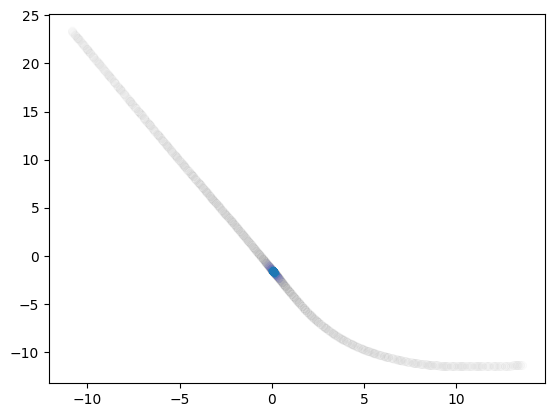

In [7]:
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt

subsection = trajectories[706]


xs = np.array([s.position[0] for s in subsection])
ys = np.array([s.position[1] for s in subsection])
zs = np.array([s.position[2] for s in subsection])

xs -= np.mean(xs)
ys -= np.mean(ys)
zs -= np.mean(zs)

plt.scatter(xs, ys, alpha=0.005)
plt.show()

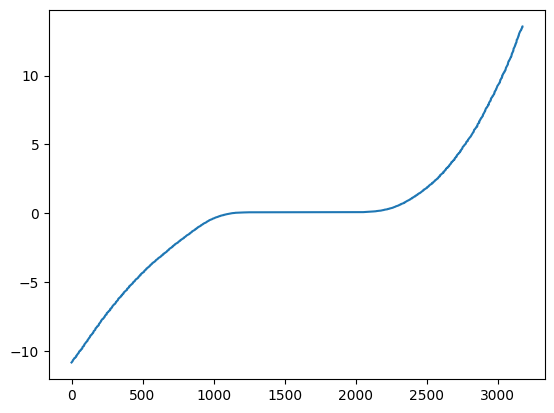

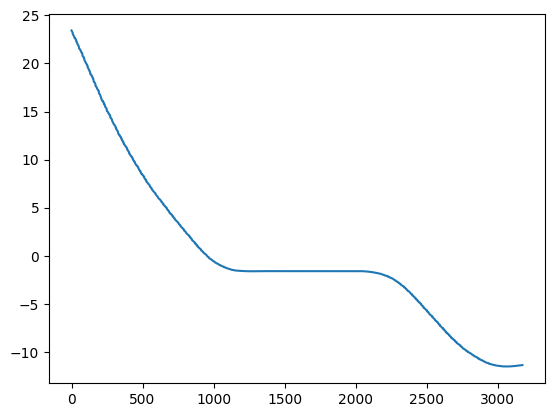

In [13]:
plt.plot(xs)
plt.show()
plt.plot(ys)
plt.show()

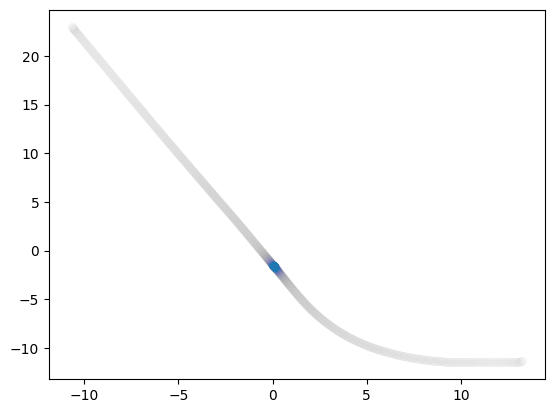

In [14]:
from scipy.ndimage import gaussian_filter1d


x_smoothed: np.ndarray = gaussian_filter1d([s.position[0] for s in subsection], 30, mode='nearest')
y_smoothed: np.ndarray = gaussian_filter1d([s.position[1] for s in subsection], 30, mode='nearest')
z_smoothed: np.ndarray = gaussian_filter1d([s.position[2] for s in subsection], 30, mode='nearest')

x_smoothed -= np.mean(x_smoothed)
y_smoothed -= np.mean(y_smoothed)
z_smoothed -= np.mean(z_smoothed)

plt.scatter(x_smoothed, y_smoothed, alpha=0.005)
plt.show()

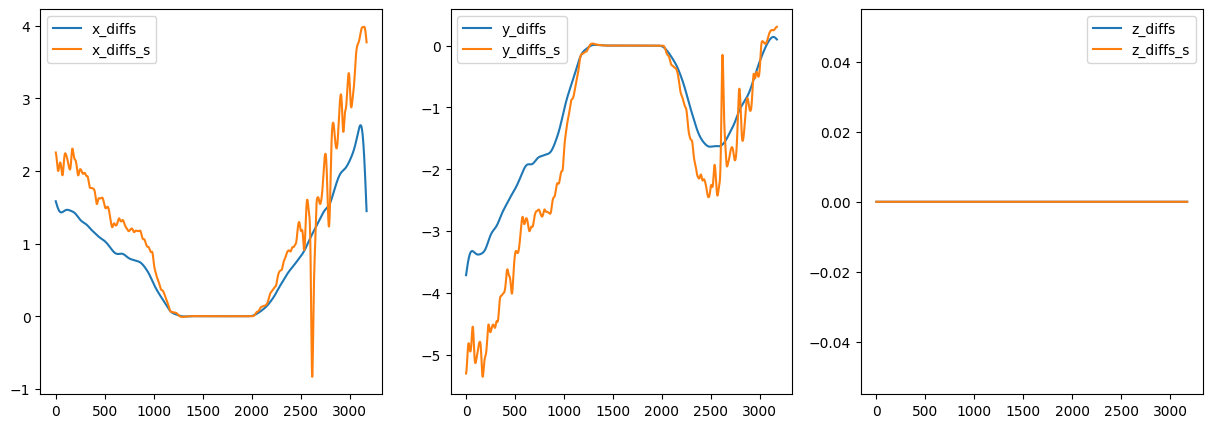

In [25]:
from scipy.ndimage import gaussian_filter1d

subsection = trajectories[706]

x_diffs_a: list[float] = []

y_diffs_a: list[float] = []

z_diffs_a: list[float] = []

for i in range(len(subsection)-1):
    s0 = subsection[i]
    s1 = subsection[i+1]

    x_diffs_a.append(s1.position[0] - s0.position[0])

    y_diffs_a.append(s1.position[1] - s0.position[1])

    z_diffs_a.append(s1.position[2] - s0.position[2])



x_diffs = np.array(x_diffs_a)
y_diffs = np.array(y_diffs_a)
z_diffs = np.array(z_diffs_a)



x_diffs:np.ndarray = gaussian_filter1d(x_diffs, 30, mode='nearest')
x_diffs *= 100

y_diffs:np.ndarray = gaussian_filter1d(y_diffs, 30, mode='nearest')
y_diffs *= 100

z_diffs:np.ndarray = gaussian_filter1d(z_diffs, 30, mode='nearest')
z_diffs *= 100



times = np.array([s.timestamp for s in subsection]) / 1e6

td = np.diff(times) + 0.0001

x_diffs_s = np.diff([s.position[0] for s in subsection]) / td
y_diffs_s = np.diff([s.position[1] for s in subsection]) / td
z_diffs_s = np.diff([s.position[2] for s in subsection]) / td


x_diffs_s = gaussian_filter1d(x_diffs_s, 10, mode='nearest')
y_diffs_s = gaussian_filter1d(y_diffs_s, 10, mode='nearest')
z_diffs_s = gaussian_filter1d(z_diffs_s, 10, mode='nearest')


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(x_diffs, label='x_diffs')
plt.plot(x_diffs_s, label='x_diffs_s')
plt.legend()    

plt.subplot(1, 3, 2)
plt.plot(y_diffs, label='y_diffs')
plt.plot(y_diffs_s, label='y_diffs_s')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(z_diffs, label='z_diffs')
plt.plot(z_diffs_s, label='z_diffs_s')
plt.legend()

plt.show()


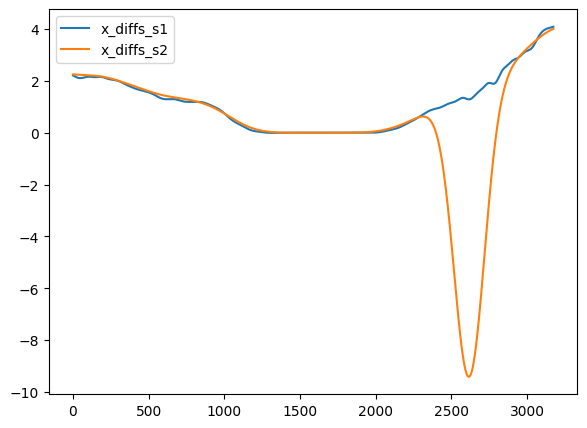

In [53]:
x_diffs_s1 = np.diff([s.position[0] for s in subsection]) / np.clip(np.diff(times), 0.0005, None)
x_diffs_s2 = np.diff([s.position[0] for s in subsection]) / (np.diff(times))

x_diffs_s1 = gaussian_filter1d(x_diffs_s1, 30, mode='nearest')
x_diffs_s2 = gaussian_filter1d(x_diffs_s2, 100, mode='nearest')

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(x_diffs_s1, label='x_diffs_s1')
plt.plot(x_diffs_s2, label='x_diffs_s2')
plt.legend()


(array([ 50.,  19.,  23.,  28.,  18.,  28.,  23.,  18.,  23.,  21.,  25.,
         22.,  28.,  15.,  26.,  23.,  21.,  17.,  22.,  19.,  17.,  14.,
         18.,  18.,  16.,  19.,  16.,  14.,   5.,  13.,  15.,  10.,  13.,
         13.,   9.,  16.,  13.,  12.,  10.,  12.,   7.,  11.,  11.,  10.,
         14.,  10.,  13.,   9.,  13.,  11.,   5.,   9.,  14.,   9.,   8.,
         10.,   8.,   7.,  14.,  10.,   7.,  10.,  10.,   7.,   6.,   4.,
          5.,   7.,  10.,  11.,   6.,   9.,   7.,   6.,   5.,  10.,  10.,
          9.,  10.,  11.,  13.,  10.,   9.,  13.,   5.,   5.,  10.,   3.,
          8.,  11.,   5.,  10.,   8.,   8.,  10.,   3.,   3.,  11.,  13.,
          6.,   7.,   6.,   6.,  11.,  22.,  19.,   9.,   6.,   7.,  11.,
          6.,   6.,   5.,   4.,  10.,   9.,   5.,  17.,   6.,   6.,   9.,
          6.,   4.,   6.,   4.,   7.,   5.,  13.,   8.,   6.,   9.,   6.,
          6.,   4.,   6.,   8.,   4.,   8.,   7.,   9.,   3.,   9.,   0.,
          1.,   7.,   6.,  11.,   6., 

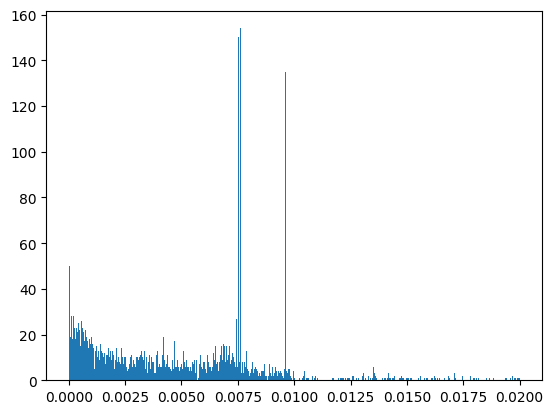

In [43]:
plt.hist(np.diff(times), bins=500, range=(0, 0.02))

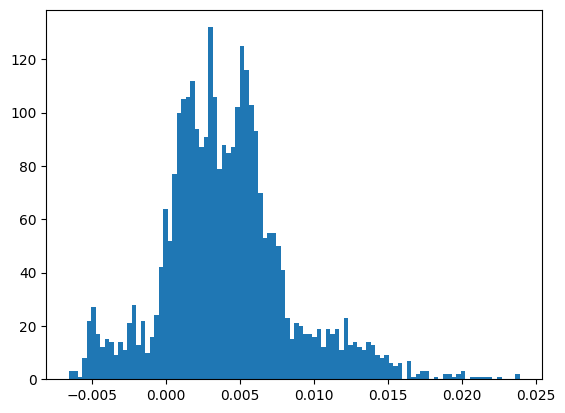

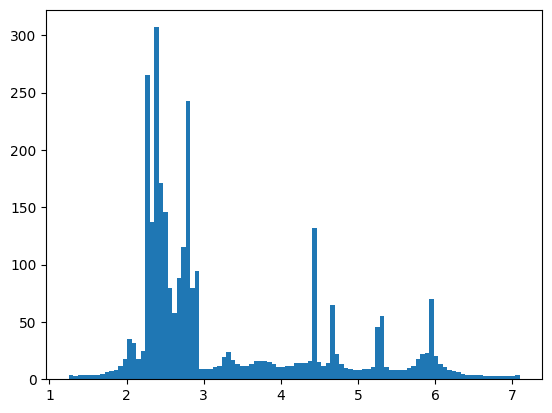

In [36]:
import numpy as np

def normalize_angle(angle: float) -> float:
    """
    Normalize the angle to [-pi, pi)
    """
    return (angle + np.pi) % (2 * np.pi) - np.pi


headings = [Rotation.from_quat(s.quaternion).as_euler('xyz')[2] for s in subsection[:-1]]

hdiffs = []
vmags = []

for heading, vx, vy in zip(headings, x_diffs, y_diffs):
    veldir = np.arctan2(vy, vx)
    hdiff = normalize_angle(heading - veldir)
    hdiffs.append(hdiff)
    vmags.append(np.sqrt(vx**2 + vy**2))

hdiffs_arr = np.array(hdiffs)

plt.hist(hdiffs_arr, bins=100)
plt.show()
plt.hist(vmags, bins=100)
plt.show()

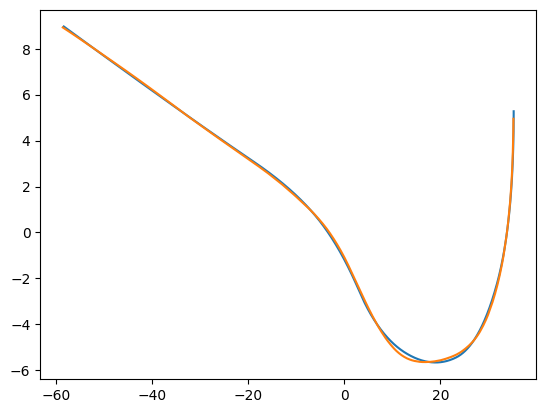

In [63]:
from scipy.interpolate import UnivariateSpline

timestamps_micros = np.array([s.timestamp for s in subsection])
timestamps = (timestamps_micros - timestamps_micros[0]) / 1e6

x_src = np.array([s.position[0] for s in subsection])
y_src = np.array([s.position[1] for s in subsection])

x_src -= x_src.mean()
y_src -= y_src.mean()

x_spline = UnivariateSpline(timestamps, x_src, k=2, s=0.01*len(timestamps))
y_spline = UnivariateSpline(timestamps, y_src, k=2, s=0.01*len(timestamps))

sampled_timestamps = np.arange(timestamps[0], timestamps[-1], 0.01)

x_sampled = x_spline(sampled_timestamps)
y_sampled = y_spline(sampled_timestamps)

plt.plot(x_sampled, y_sampled)
plt.plot(x_src, y_src)

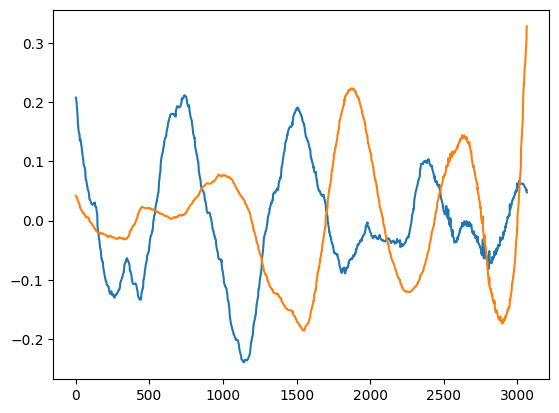

In [68]:
plt.plot( x_spline(timestamps) - x_src)
plt.plot( y_spline(timestamps) - y_src)

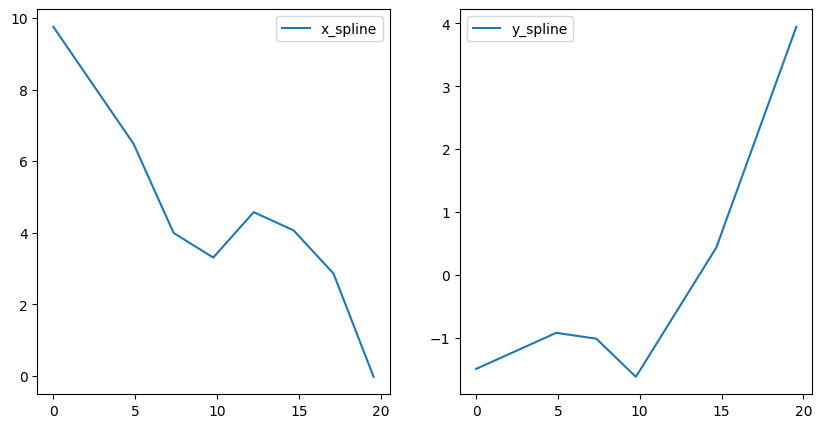

In [64]:
xvel_spline = x_spline.derivative()(sampled_timestamps)
yvel_spline = y_spline.derivative()(sampled_timestamps)

start_time = timestamps[0]
sampled_timestamps_at_zero = np.array(sampled_timestamps) - start_time
timestamps_at_zero = np.array(timestamps[:-1]) - start_time

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(sampled_timestamps_at_zero, xvel_spline, label='x_spline')
plt.legend()    

plt.subplot(1, 2, 2)
plt.plot(sampled_timestamps_at_zero, yvel_spline, label='y_spline')
plt.legend()


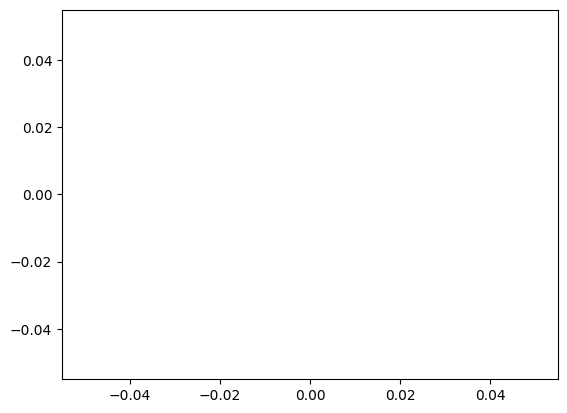

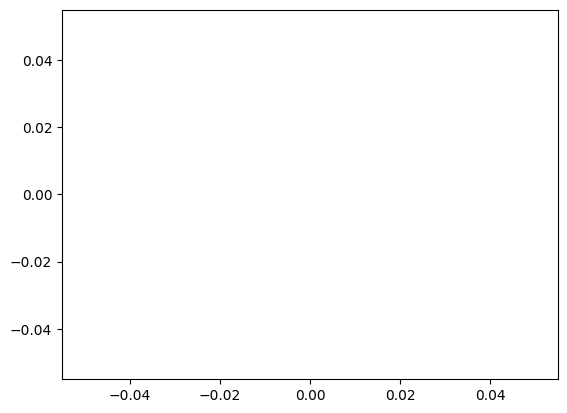

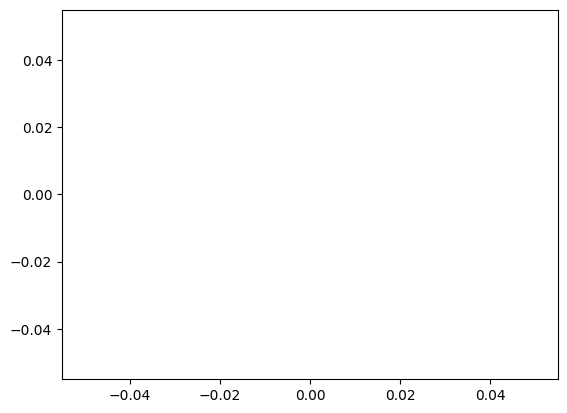

In [60]:
xs_spline = x_spline(sampled_timestamps)
ys_spline = y_spline(sampled_timestamps)

xvel_spline = x_spline.derivative()(sampled_timestamps)
yvel_spline = y_spline.derivative()(sampled_timestamps)

xacc_spline = x_spline.derivative(2)(sampled_timestamps)
yacc_spline = y_spline.derivative(2)(sampled_timestamps)


tmin = 6500
tmax = 6800

plt.scatter(sampled_timestamps[tmin:tmax], xs_spline[tmin:tmax])
plt.scatter(sampled_timestamps[tmin:tmax], ys_spline[tmin:tmax])

plt.show()


plt.plot(sampled_timestamps[tmin:tmax], xvel_spline[tmin:tmax])
plt.plot(sampled_timestamps[tmin:tmax], yvel_spline[tmin:tmax])

plt.show()

plt.plot(sampled_timestamps[tmin:tmax], xacc_spline[tmin:tmax])
plt.plot(sampled_timestamps[tmin:tmax], yacc_spline[tmin:tmax])

plt.show()

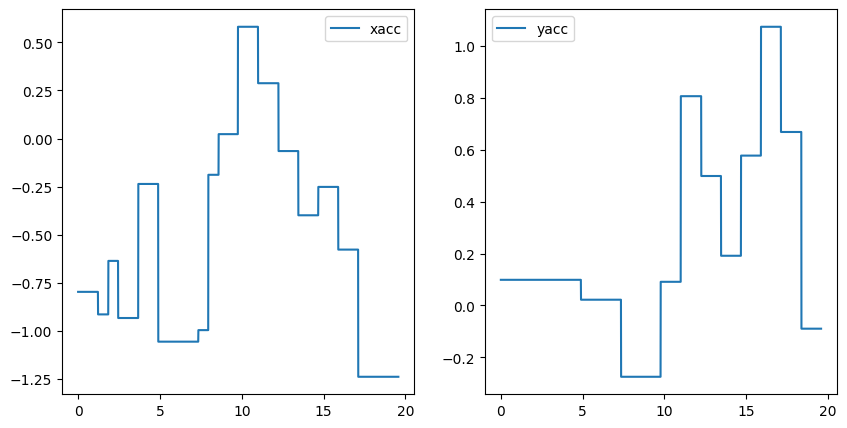

In [61]:
xacc_spline = x_spline.derivative(2)(sampled_timestamps)
yacc_spline = y_spline.derivative(2)(sampled_timestamps)

start_time = timestamps[0]
sampled_timestamps_at_zero = np.array(sampled_timestamps) - start_time

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(sampled_timestamps_at_zero, xacc_spline, label='xacc')
plt.legend()    

plt.subplot(1, 2, 2)
plt.plot(sampled_timestamps_at_zero, yacc_spline, label='yacc')
plt.legend()

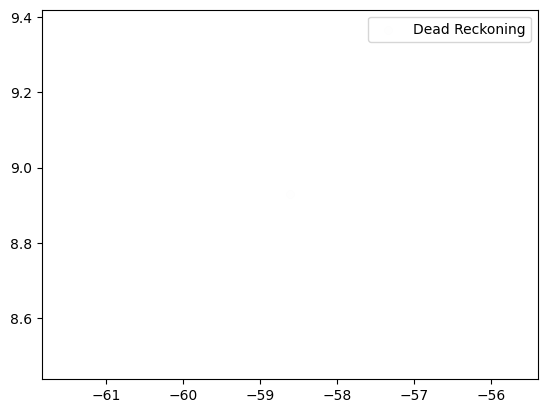

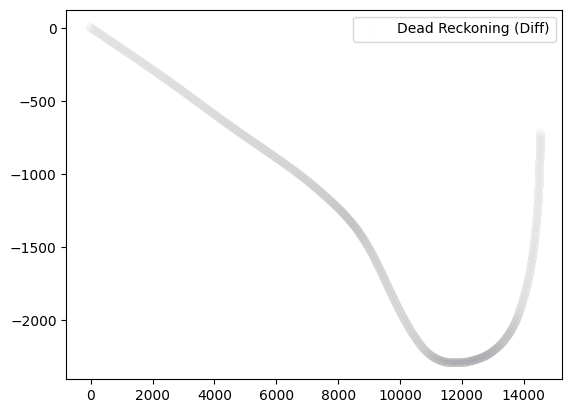

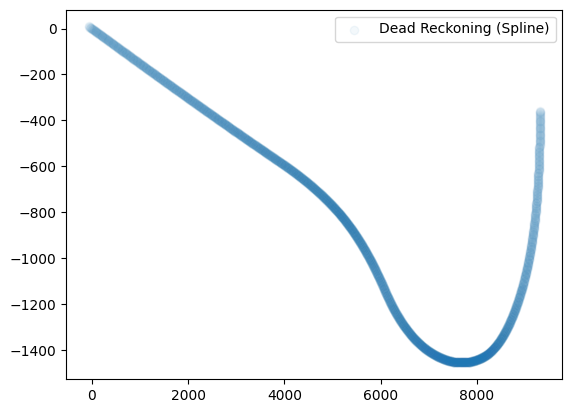

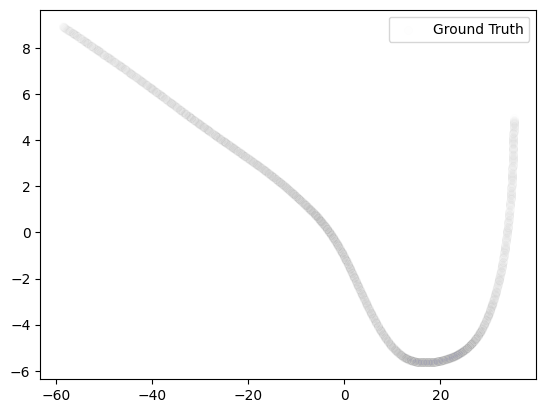

In [71]:
xs = np.array([s.position[0] for s in subsection[:-1]])
ys = np.array([s.position[1] for s in subsection[:-1]])

xs -= np.mean(xs)
ys -= np.mean(ys)

dead_reckoned_xs_vel = [xs[0]]
dead_reckoned_ys_vel = [ys[0]]

dead_reckoned_xs_diff = [xs[0]]
dead_reckoned_ys_diff = [ys[0]]

dead_reckoned_xs_spline = [xs[0]]
dead_reckoned_ys_spline = [ys[0]]

for i in range(1, len(xs)):

    dead_reckoned_xs_diff.append(dead_reckoned_xs_diff[-1] + x_diffs_s[i])
    dead_reckoned_ys_diff.append(dead_reckoned_ys_diff[-1] + y_diffs_s[i])


for i in range(1, len(xvel_spline)):
    dead_reckoned_xs_spline.append(dead_reckoned_xs_spline[-1] + xvel_spline[i])
    dead_reckoned_ys_spline.append(dead_reckoned_ys_spline[-1] + yvel_spline[i])

plt.scatter(dead_reckoned_xs_vel, dead_reckoned_ys_vel, label='Dead Reckoning', alpha=0.002)
plt.legend()
plt.show()
plt.scatter(dead_reckoned_xs_diff, dead_reckoned_ys_diff, label='Dead Reckoning (Diff)', alpha=0.002)
plt.legend()
plt.show()
plt.scatter(dead_reckoned_xs_spline, dead_reckoned_ys_spline, label='Dead Reckoning (Spline)', alpha=0.05)
plt.legend()
plt.show()
plt.scatter(xs, ys, label='Ground Truth', alpha=0.002)
plt.legend()
plt.show()

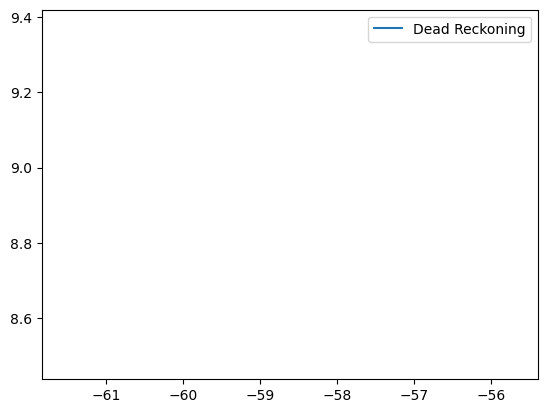

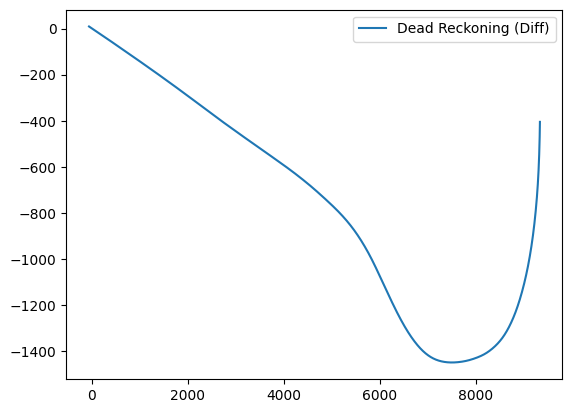

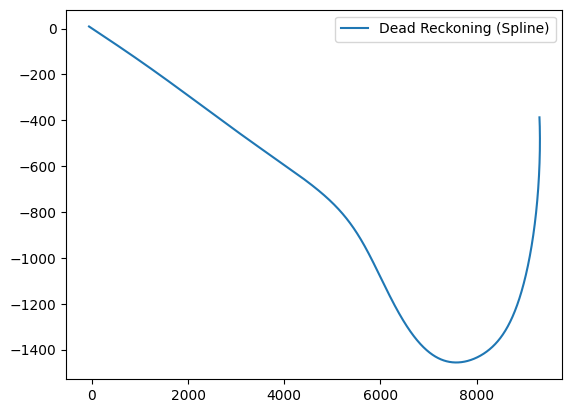

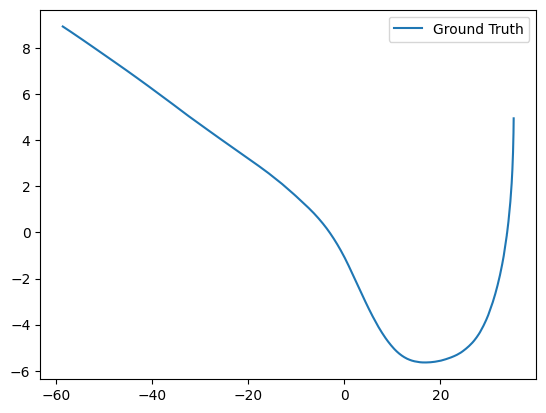

In [47]:
plt.plot(dead_reckoned_xs_vel, dead_reckoned_ys_vel, label='Dead Reckoning')
plt.legend()
plt.show()
plt.plot(dead_reckoned_xs_diff, dead_reckoned_ys_diff, label='Dead Reckoning (Diff)')
plt.legend()
plt.show()
plt.plot(dead_reckoned_xs_spline, dead_reckoned_ys_spline, label='Dead Reckoning (Spline)')
plt.legend()
plt.show()
plt.plot(xs, ys, label='Ground Truth')
plt.legend()
plt.show()